# Image classification with TensorFlow Lite Model Maker

## Part 1: TensorFlow Evaluation

Import the required packages

In [54]:
import tensorflow
print(tensorflow.__version__)

2.10.0


In [55]:
import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt

import time
from datetime import datetime
import multiprocessing
import csv   

# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [56]:
# Constants
training_dataset_path = 'gaf_sample_tv/'
tflite_model_filename = 'model.tflite'
img_height = 500
img_width = 500
batch_size = 32
EPOCHS = 50

Step 1.   Load input data specific to an on-device ML app. Split it into training data and testing data.

In [57]:
# Create dataset from folder
train_data = tf.keras.utils.image_dataset_from_directory(
  training_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
  training_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5480 files belonging to 2 classes.
Using 4384 files for training.
Found 5480 files belonging to 2 classes.
Using 4384 files for training.


Split it to training data (80%), validation data (10%, optional) and testing data (10%).

Show 25 image examples with labels.

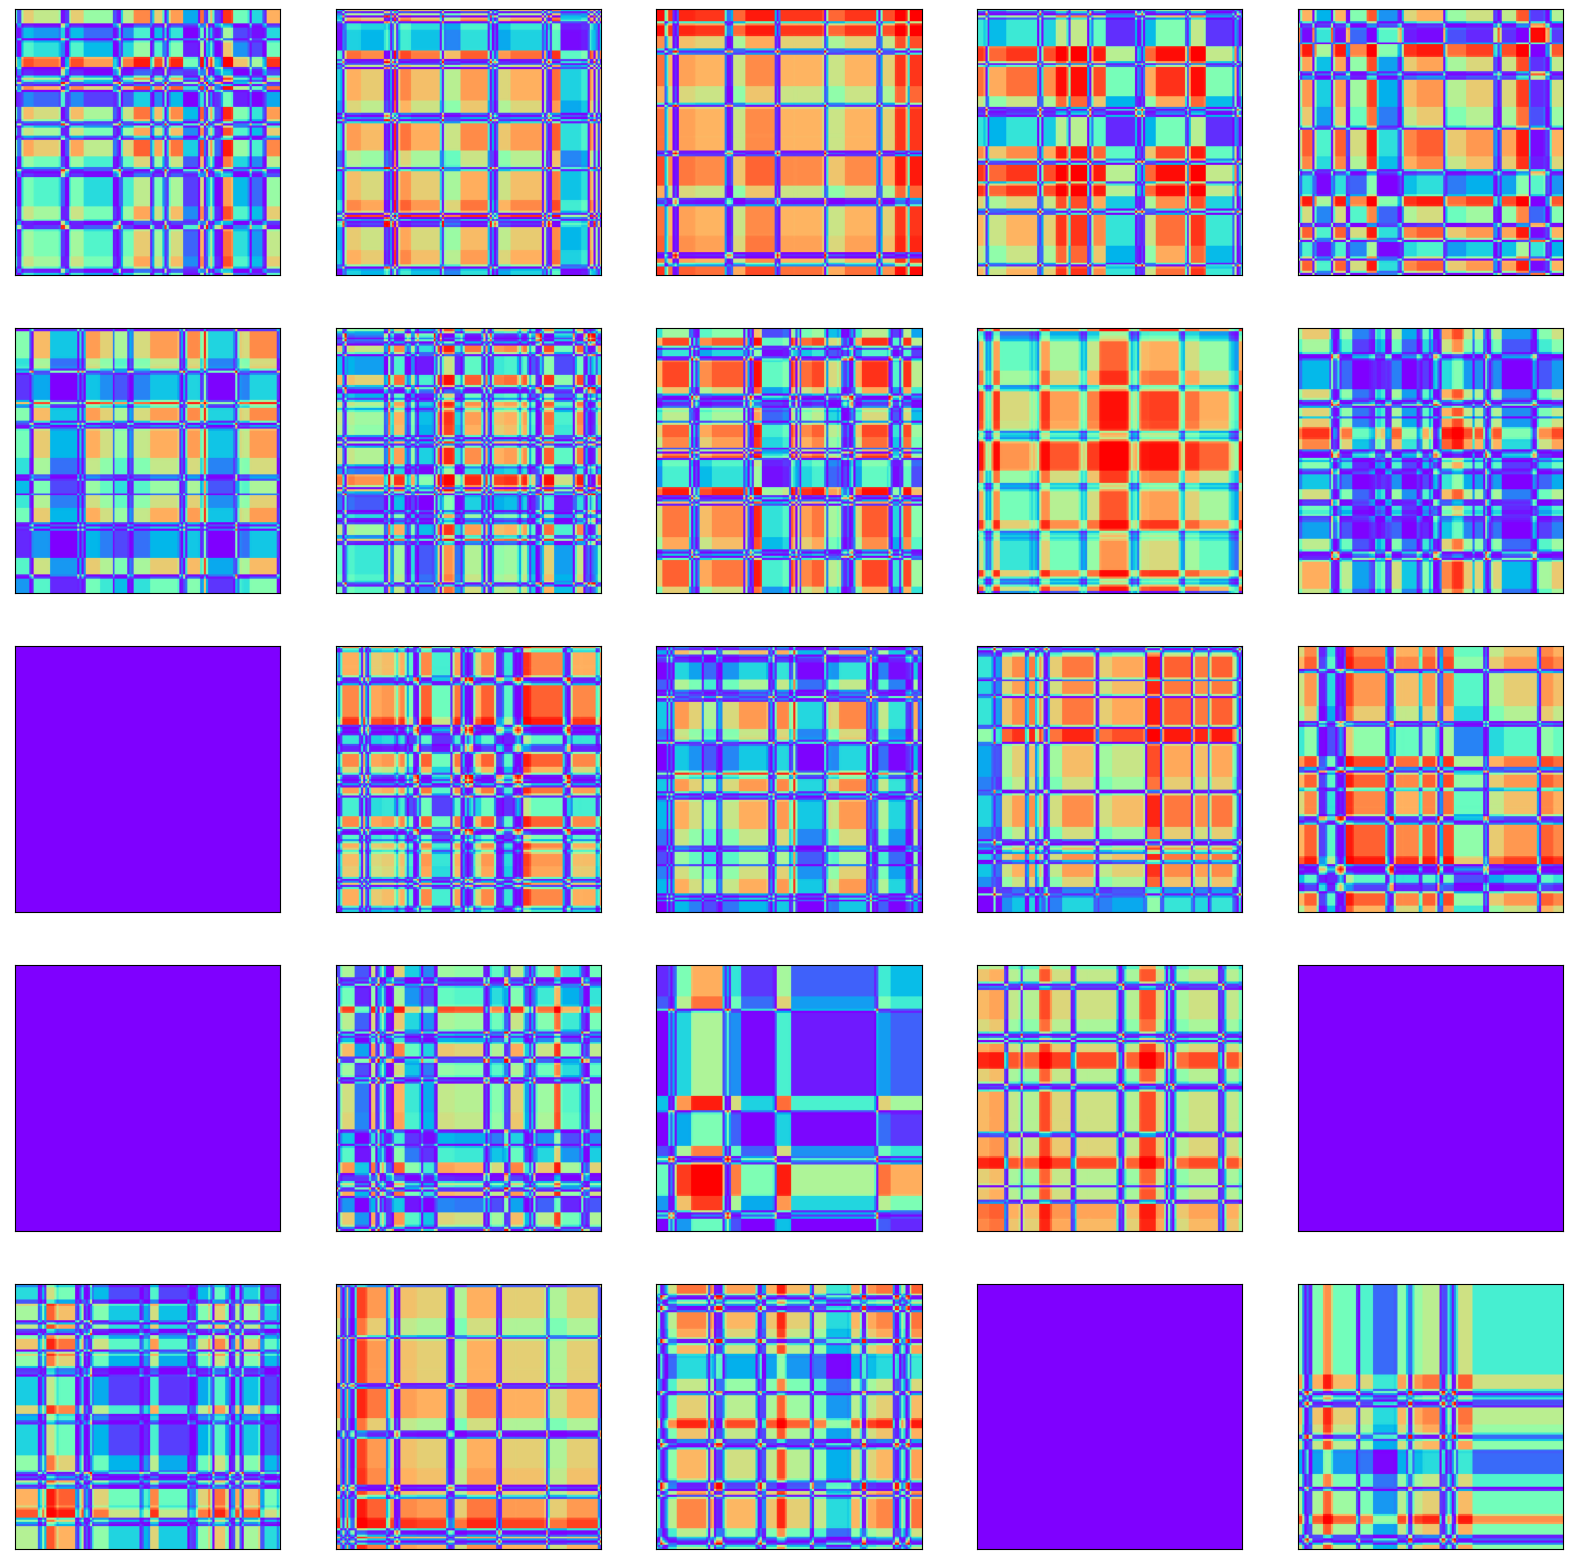

In [72]:

plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_data.unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow((image.numpy()).astype(np.uint8), cmap=plt.cm.hsv)
  # plt.xlabel(label.numpy())
plt.show()

### Step 1: Customize the TensorFlow Model

Create a custom image classifier model based on the loaded data. The default model is EfficientNet-Lite0.


In [ ]:
training_time_start = time.clock()
model = image_classifier.create(train_data, validation_data=validation_data, epochs=EPOCHS)
training_time_elapsed = (time.clock() - training_time_start)
print('training_time_elapsed:', training_time_elapsed)

: 

Have a look at the detailed model structure.

In [ ]:
model.summary()

: 

### Step 2: Evaluate the Customized Model

Evaluate the result of the model, get the loss and accuracy of the model.

In [ ]:
eval_time_start = time.clock()
loss, accuracy = model.evaluate(test_data)
eval_time_elapsed = (time.clock() - eval_time_start)
print('eval_time_elapsed:', eval_time_elapsed)

: 

In [ ]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "epoch={:.3f}, max={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.32)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.16), **kw)

def annot_min(x,y, ax=None):
    xmax = x[np.argmin(y)]
    ymax = y.min()
    text= "epoch={:.3f}, min={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.56), **kw)

sns.set(rc={'figure.figsize':(15,15), 'figure.facecolor':'white', 'axes.facecolor': 'white'}, font_scale=2)
plt.figure(figsize=(10,10))
plt.plot(model.history.history['accuracy'], linewidth=3)
plt.plot(model.history.history['val_accuracy'], linewidth=3)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(color='black', linestyle='-', linewidth=0.15, which='both')
# annot_max(np.arange(0,50,1),np.array(model.history.history['accuracy']))
# annot_max(np.arange(0,50,1),np.array(model.history.history['val_accuracy']))
plt.show()

plt.figure(figsize=(10,10))
plt.plot(model.history.history['loss'], linewidth=3)
plt.plot(model.history.history['val_loss'], linewidth=3)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(color='black', linestyle='-', linewidth=0.15, which='both')
# annot_max(np.arange(0,50,1),np.array(model.history.history['loss']))
# annot_min(np.arange(0,50,1),np.array(model.history.history['val_loss']))

plt.show()

: 

We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
sns.set(rc={'figure.figsize':(15,15), 'figure.facecolor':'white', 'axes.facecolor': 'white'}, font_scale=1)
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(50, 50))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

: 

If the accuracy doesn't meet the app requirement, one could refer to [Advanced Usage](#scrollTo=zNDBP2qA54aK) to explore alternatives such as changing to a larger model, adjusting re-training parameters etc.

### Step 3: Export to TensorFlow Lite Model

Convert the trained model to TensorFlow Lite model format with [metadata](https://www.tensorflow.org/lite/convert/metadata) so that you can later use in an on-device ML application. The label file and the vocab file are embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster.
The default post-training quantization technique is full integer quantization for the image classification task.

In [ ]:
model_export_time_start = time.clock()
model.export(export_dir='.', tflite_filename='epochs-' + str(EPOCHS) + '-' + tflite_model_filename)
model_export_time_elapsed = (time.clock() - model_export_time_start)
print('model_export_time_elapsed:', model_export_time_elapsed)

: 

In [ ]:
model.export(export_dir='.', export_format=ExportFormat.LABEL)

: 

You can also evaluate the tflite model with the `evaluate_tflite` method.

In [ ]:
tflite_eval_time_start = time.process_time()
tflite_accuracy = model.evaluate_tflite('epochs-' + str(EPOCHS) + '-' + tflite_model_filename, test_data)
print('TFLite accuracy:', tflite_accuracy)
tflite_eval_time_elapsed = time.process_time()
tflite_eval_time_elapsed = (tflite_eval_time_elapsed - tflite_eval_time_start)
print('tflite_eval_time_elapsed:', tflite_eval_time_elapsed)

: 